# CIFAR-10 Convolutional neural network

## Exercise - Load data

> **Exercise**: Load the CIFAR-10 data. Normalize the images and split them into train, validation and test sets. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

### Load and normalize data

Normalization is done the same way we've done in previous unit (minus 128 and divide by 255)

In [1]:
import numpy as np
import os

CIFAR_NUMBER=60
IMG_WIDTH=32
IMG_HEIGHT=32
IMG_NBCOLOR=3

# Load data
with np.load(os.path.join('data', 'cifar10-{}k.npz'.format(CIFAR_NUMBER)), allow_pickle=False) as npz_file:
    cifar = dict(npz_file.items())
    
# Convert pixels into floating point numbers
data = cifar['data'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255
print("CIFAR10 data shape:",data.shape)

CIFAR10 data shape: (60000, 3072)


### Create train and valid dataset

In [2]:
from sklearn.model_selection import train_test_split

# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Reshape images: 32 by 32 with 3 (RGB) color channels
    data.reshape(-1, 32, 32, 3),
    cifar['labels'],
    test_size=2000, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (58000, 32, 32, 3) (58000,)
Valid: (1000, 32, 32, 3) (1000,)
Test: (1000, 32, 32, 3) (1000,)


### Define batch generator function

In [3]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Exercise - Create and train a ConvNet

> **Exercise:** Create a convolutional neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained kernel weights of the first convolutional layer in a variable.

### Build placeholders

In [4]:
import tensorflow as tf

# Define graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, IMG_WIDTH, IMG_HEIGHT, IMG_NBCOLOR])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    print("Input:", X.shape)

Input: (?, 32, 32, 3)


### Build first convolution

In [5]:
with graph.as_default():
    # Convolution
    conv1 = tf.layers.conv2d(
        X, # Input data
        filters=64, # 16 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv1' # Add name
    )
    
    
    
    # Get the kernel weights
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    print("Convolutional layer 1:", conv1.shape)

Convolutional layer 1: (?, 16, 16, 64)


### Build first max pool

In [6]:
with graph.as_default():
    # Max pooling layer
    pool1 = tf.layers.max_pooling2d(
        conv1, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
    )
    print("Max pool 1:", pool1.shape)

Max pool 1: (?, 8, 8, 64)


### Build second convolution

In [7]:
with graph.as_default():
    # Convolution
    conv2 = tf.layers.conv2d(
        pool1, # Max pooling output
        filters=64, # 16 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )
    
    # Get the kernel weights
    with tf.variable_scope('conv2', reuse=True):
        conv2_kernels = tf.get_variable('kernel')
    
    print("Convultional layer 2:", conv2.shape)

Convultional layer 2: (?, 8, 8, 64)


### Build second max pool

In [8]:
with graph.as_default():
    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
    
    print("Max pool 2:", pool2.shape)

Max pool 2: (?, 4, 4, 64)


In [9]:
with graph.as_default():    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    
    print("Flatten output:", flat_output.shape)

Flatten output: (?, 1024)


### Create multilayer neural network

Based on the flatten output build previously, let's build a *hidden* and *logits* layers.

Note that the flatten output layer will be reduced using a 0.5 dropout on it.

In [10]:
with graph.as_default():
    
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    # dropout of the flat_output
    flat_output = tf.layers.dropout(
        flat_output, rate=0.5, seed=0, training=training)
    print("Dropout:", flat_output.shape)

    # Hidden layer with 256 units
    hidden = tf.layers.dense(
        flat_output, 256, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    print("Fully connected layer:", hidden.shape)

    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    print("Output layer:", logits.shape)

Dropout: (?, 1024)
Fully connected layer: (?, 256)
Output layer: (?, 10)


### Define regression functions

In [11]:
with graph.as_default():

    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)
    # gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

### Evaluate the accuracy on the validation set after each epoch

In [12]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(15):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True # Apply dropout
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()

    

Epoch 1 - valid: 0.526 train: 0.436 (mean)
Epoch 2 - valid: 0.647 train: 0.557 (mean)
Epoch 3 - valid: 0.687 train: 0.609 (mean)
Epoch 4 - valid: 0.708 train: 0.646 (mean)
Epoch 5 - valid: 0.743 train: 0.668 (mean)
Epoch 6 - valid: 0.749 train: 0.685 (mean)
Epoch 7 - valid: 0.738 train: 0.697 (mean)
Epoch 8 - valid: 0.762 train: 0.710 (mean)
Epoch 9 - valid: 0.755 train: 0.717 (mean)
Epoch 10 - valid: 0.767 train: 0.727 (mean)
Epoch 11 - valid: 0.791 train: 0.730 (mean)
Epoch 12 - valid: 0.762 train: 0.743 (mean)
Epoch 13 - valid: 0.787 train: 0.746 (mean)
Epoch 14 - valid: 0.791 train: 0.751 (mean)
Epoch 15 - valid: 0.779 train: 0.755 (mean)


## Exercise - Visualize kernels

> **Exercise**: Plot the kernels from the first convolutional layer with the `imshow()` function.

**Hint**: Remember that the `imshow()` function expects values between 0 and 1 for 3-dimensional arrays.

NameError: name 'kernels' is not defined

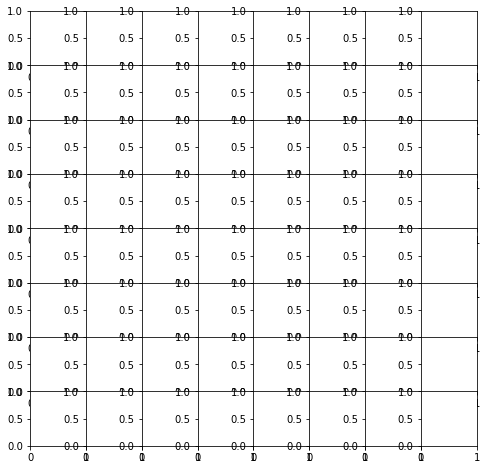

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()